In [1]:
# Required Packages
import numpy as np
import pandas as pd
import wfdb
import pywt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)

# Path to MIT-BIH data
data = 'mitdb/'

# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Abnormal & Normal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
normal = ['N']

# Wavelet denoising
def wavelet_denoising(signal, wavelet='db6', level=1):
    coeff = pywt.wavedec(signal, wavelet, mode='per')
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet, mode='per')

# Apply denoising to dataset
def denoise_ecg_signals(signals):
    return np.array([wavelet_denoising(signal) for signal in signals])

# Load ECG signal & annotation
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal[:, 0]  # First channel
    return p_signal, annotation.symbol, annotation.sample

# Extract X (ECG segment), Y (label), sym (beat symbol)
def build_XY(p_signal, df_ann, num_cols, abnormal):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.empty((num_rows, 1), dtype='<U2')  # for string symbols
    sym = []
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max(0, atr_sample - num_sec * fs)
        right = min(len(p_signal), atr_sample + num_sec * fs)
        x = p_signal[left:right]
        if len(x) == num_cols:
            X[max_row, :] = x
            Y[max_row, :] = atr_sym  # keep the actual beat symbol
            sym.append(atr_sym)
            max_row += 1

    return X[:max_row, :], Y[:max_row, :], sym

# Create dataset from all patients
def make_dataset(patients, num_sec, fs, abnormal):
    num_cols = 2 * num_sec * fs
    X_all = []
    Y_all = []
    sym_all = []

    for pt in patients:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann[df_ann.atr_sym.isin(abnormal + ['N'])]
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal)
        if len(X) > 0:
            X_all.append(X)
            Y_all.append(Y)
            sym_all += sym

    X_all = np.vstack(X_all)
    Y_all = np.vstack(Y_all)
    return X_all, Y_all, sym_all

# Parameters
num_sec = 3
fs = 360

# Prepare dataset
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

# Denoise
X_all_denoised = denoise_ecg_signals(X_all)

# Normalize
scaler = MinMaxScaler()
X_all_normalized = scaler.fit_transform(X_all_denoised)

Original class distribution: Counter({6: 74795, 5: 8052, 7: 7235, 9: 7113, 0: 6999, 1: 2536, 12: 982, 3: 801, 13: 229, 10: 150, 2: 106, 4: 83, 11: 16, 8: 2})
Final class distribution: Counter({6: 74795, 5: 8052, 1: 8000, 9: 8000, 0: 8000, 12: 8000, 3: 8000, 13: 8000, 10: 8000, 4: 8000, 7: 8000, 2: 8000, 11: 8000, 8: 8000})


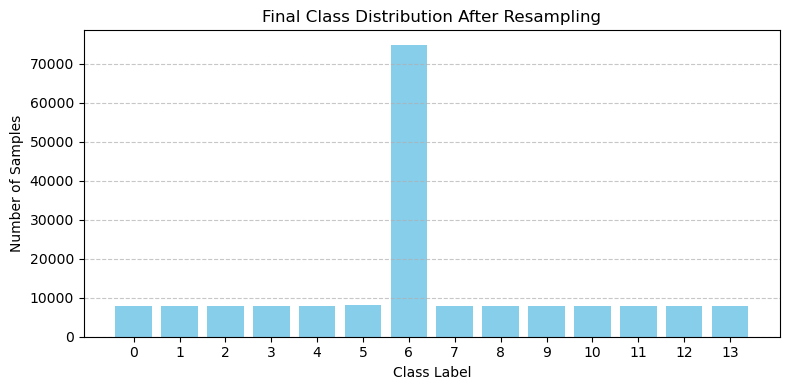

In [2]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# Encode labels
ECG_classes = ['N', 'L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ECG_classes)

Y_encoded = label_encoder.fit_transform(Y_all.ravel())

# Count original class distribution
class_counts = Counter(Y_encoded)
print("Original class distribution:", class_counts)

# Step 1: Manually oversample rare class (e.g., class 8)
rare_class = 8
rare_class_indices = np.where(Y_encoded == rare_class)[0]
num_rare_samples = len(rare_class_indices)
X_rare = X_all_normalized[rare_class_indices]
Y_rare = Y_encoded[rare_class_indices]

# Duplicate rare samples to get 8000
if num_rare_samples > 0:
    n_copies = 8000 // num_rare_samples
    remainder = 8000 % num_rare_samples
    X_rare_oversampled = np.vstack([X_rare] * n_copies + [X_rare[:remainder]])
    Y_rare_oversampled = np.array([rare_class] * 8000)
else:
    X_rare_oversampled = np.empty((0, X_all_normalized.shape[1]))
    Y_rare_oversampled = np.array([])

# Step 2: Identify underrepresented classes (excluding rare class)
underrepresented_classes = [
    cls for cls, count in class_counts.items()
    if count < 8000 and cls != rare_class
]

# Step 3: Prepare data for SMOTE
mask_under = np.isin(Y_encoded, underrepresented_classes)
X_under = X_all_normalized[mask_under]
Y_under = Y_encoded[mask_under]

# Step 4: Apply SMOTE to boost underrepresented classes to 8000
if underrepresented_classes:
    sampling_strategy = {cls: 8000 for cls in underrepresented_classes}
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(X_under, Y_under)
else:
    X_resampled, Y_resampled = X_under, Y_under

# Step 5: Keep untouched classes (≥8000 and ≠ rare class)
retain_classes = [cls for cls, count in class_counts.items()
                  if count >= 8000 and cls != rare_class]
retain_mask = np.isin(Y_encoded, retain_classes)
X_retained = X_all_normalized[retain_mask]
Y_retained = Y_encoded[retain_mask]

# Step 6: Combine all parts into final dataset
X_final = np.vstack((X_retained, X_resampled, X_rare_oversampled))
Y_final = np.hstack((Y_retained, Y_resampled, Y_rare_oversampled))

# Final check: plot new class distribution
final_counts = Counter(Y_final)
print("Final class distribution:", final_counts)

# Optional: plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(final_counts.keys(), final_counts.values(), color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Final Class Distribution After Resampling')
plt.xticks(list(final_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
# Final check
resampled_counts = Counter(Y_final)
print("Balanced class distribution:", resampled_counts)
print("Final X shape:", X_final.shape)
print("Final Y shape:", Y_final.shape)

Balanced class distribution: Counter({6: 74795, 5: 8052, 1: 8000, 9: 8000, 0: 8000, 12: 8000, 3: 8000, 13: 8000, 10: 8000, 4: 8000, 7: 8000, 2: 8000, 11: 8000, 8: 8000})
Final X shape: (178847, 2160)
Final Y shape: (178847,)


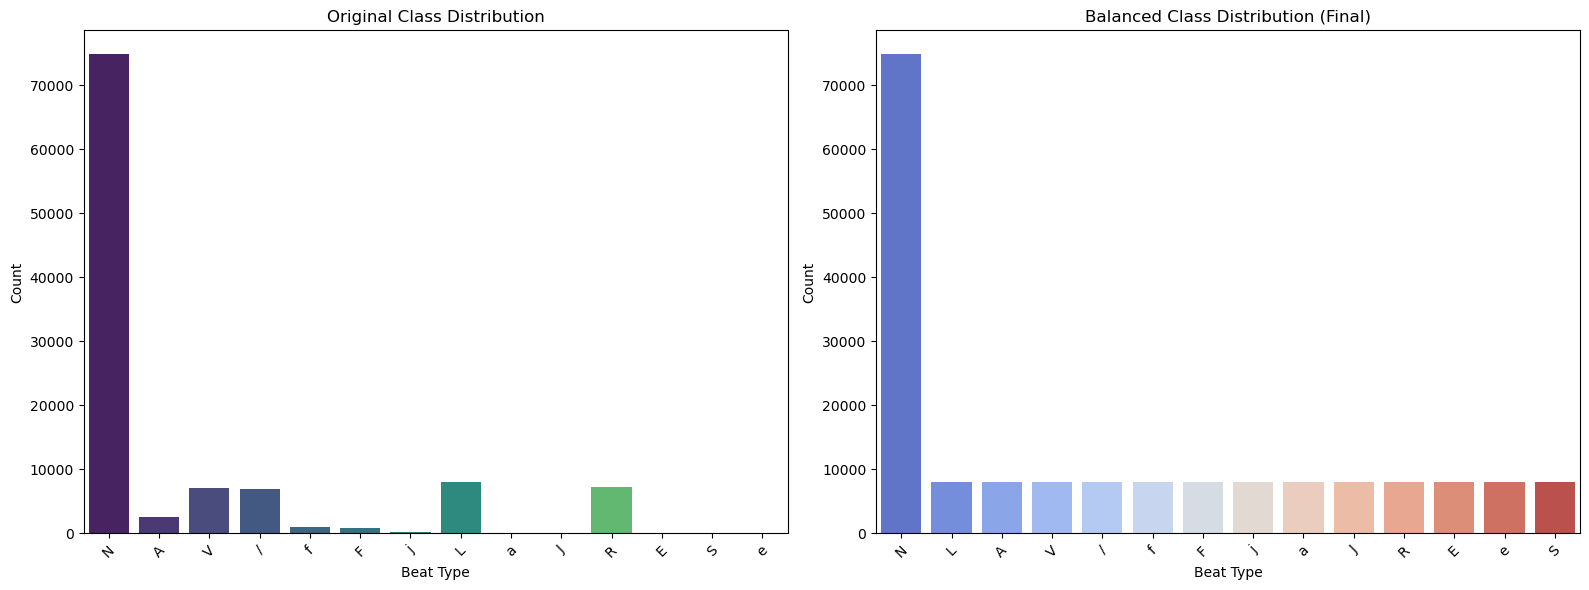

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Encode labels
ECG_classes = ['N', 'L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ECG_classes)

Y_encoded = label_encoder.fit_transform(Y_all.ravel())

# --- Original distribution ---
original_counts = Counter(Y_encoded)
original_labels = label_encoder.inverse_transform(list(original_counts.keys()))
original_freqs = list(original_counts.values())

# --- After final resampling (including class 8) ---
resampled_counts = Counter(Y_final)  
resampled_labels = label_encoder.inverse_transform(list(resampled_counts.keys()))
resampled_freqs = list(resampled_counts.values())

# --- Plotting ---
plt.figure(figsize=(16, 6))

# Plot original
plt.subplot(1, 2, 1)
sns.barplot(x=original_labels, y=original_freqs, palette='viridis')
plt.title('Original Class Distribution')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot resampled
plt.subplot(1, 2, 2)
sns.barplot(x=resampled_labels, y=resampled_freqs, palette='coolwarm')
plt.title('Balanced Class Distribution (Final)')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
from collections import Counter

# Count per class
resampled_counts = Counter(Y_final)
print("Resampled class distribution:")
for label, count in sorted(resampled_counts.items()):
    print(f"Class {label}: {count} samples")

# Total count
total_samples = sum(resampled_counts.values())
print(f"\n✅ Total resampled samples: {total_samples}")


Resampled class distribution:
Class 0: 8000 samples
Class 1: 8000 samples
Class 2: 8000 samples
Class 3: 8000 samples
Class 4: 8000 samples
Class 5: 8052 samples
Class 6: 74795 samples
Class 7: 8000 samples
Class 8: 8000 samples
Class 9: 8000 samples
Class 10: 8000 samples
Class 11: 8000 samples
Class 12: 8000 samples
Class 13: 8000 samples

✅ Total resampled samples: 178847


In [6]:
from sklearn.model_selection import train_test_split

# X_resampled, Y_resampled already from your pipeline
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.2, random_state=42, stratify=Y_final)

total_samples = X_final.shape[0]
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 178847
Training samples: 143077 (80.00%)
Testing samples: 35770 (20.00%)


In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = np.max(Y_resampled) + 1

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Add channel dimension for CNN: (samples, time_steps, channels)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-08 00:33:55.517769: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-08 00:33:55.517987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-08 00:33:55.517997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-08 00:33:55.518171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-08 00:33:55.518185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
X_train.shape[1]

2160

In [10]:
import time
# Start timer
start_time = time.time()

history = model.fit(
    X_train_cnn, y_train_cat,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_cnn, y_test_cat)
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-08 00:38:59.923732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1118/1118 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.6322 - loss: 1.2782 - val_accuracy: 0.9321 - val_loss: 0.2340
Epoch 2/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 107s 96ms/step - accuracy: 0.8785 - loss: 0.4664 - val_accuracy: 0.9501 - val_loss: 0.1822
Epoch 3/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8878 - loss: 0.5033 - val_accuracy: 0.9546 - val_loss: 0.2150
Epoch 4/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.8860 - loss: 0.8011 - val_accuracy: 0.9587 - val_loss: 0.3640
Epoch 5/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.8886 - loss: 1.4472 - val_accuracy: 0.9567 - val_loss: 0.7903
Epoch 6/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8985 - loss: 2.4606 - val_accuracy: 0.9553 - val_loss: 1.6250
Epoch 7/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9057 - loss: 4.0146 - val_accuracy: 0.9463 - val_loss: 3.6386
Epoch 8/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.9104 - lo

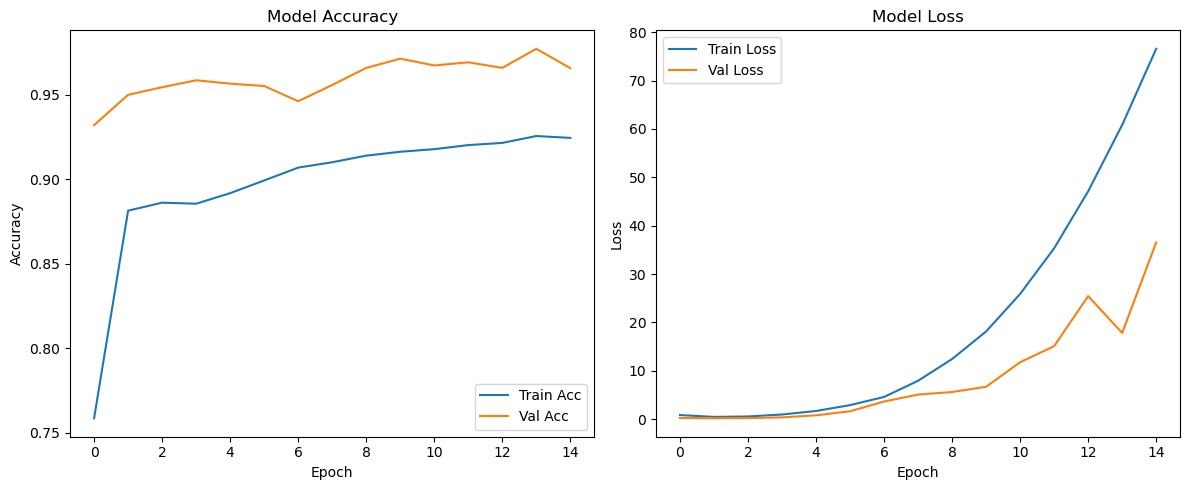

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9658
Precision : 0.9622
Recall    : 0.9719
F1-score  : 0.9661



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9815    0.9969    0.9891      1600
           1     0.9820    0.8531    0.9130      1600
           2     0.9981    1.0000    0.9991      1600
           3     0.8267    0.9513    0.8846      1600
           4     0.9668    1.0000    0.9831      1600
           5     0.9738    0.9702    0.9720      1611
           6     0.9764    0.9556    0.9659     14959
           7     0.9886    0.9756    0.9821      1600
           8     1.0000    1.0000    1.0000      1600
           9     0.9537    0.9269    0.9401      1600
          10     0.9858    0.9981    0.9919      1600
          11     0.9981    1.0000    0.9991      1600
          12     0.9614    0.9800    0.9706      1600
          13     0.8776    0.9994    0.9345      1600

    accuracy                         0.9658     35770
   macro avg     0.9622    0.9719    0.9661     35770
weighted avg     0.9675    0.9658    0.9660    

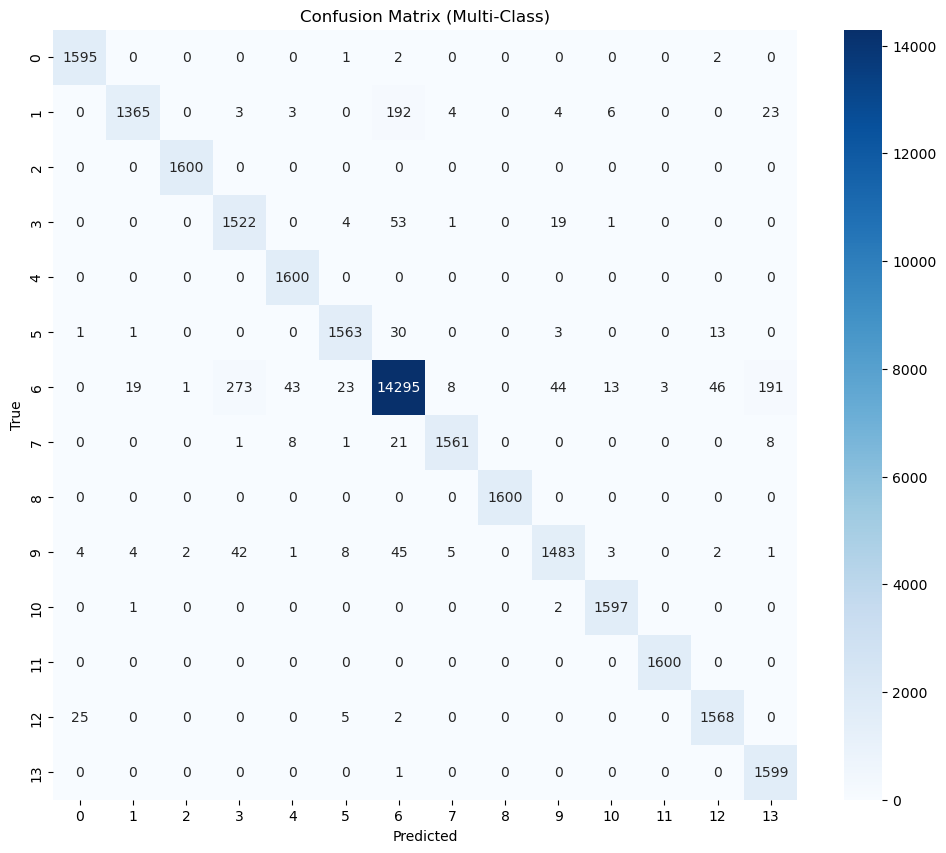

In [13]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

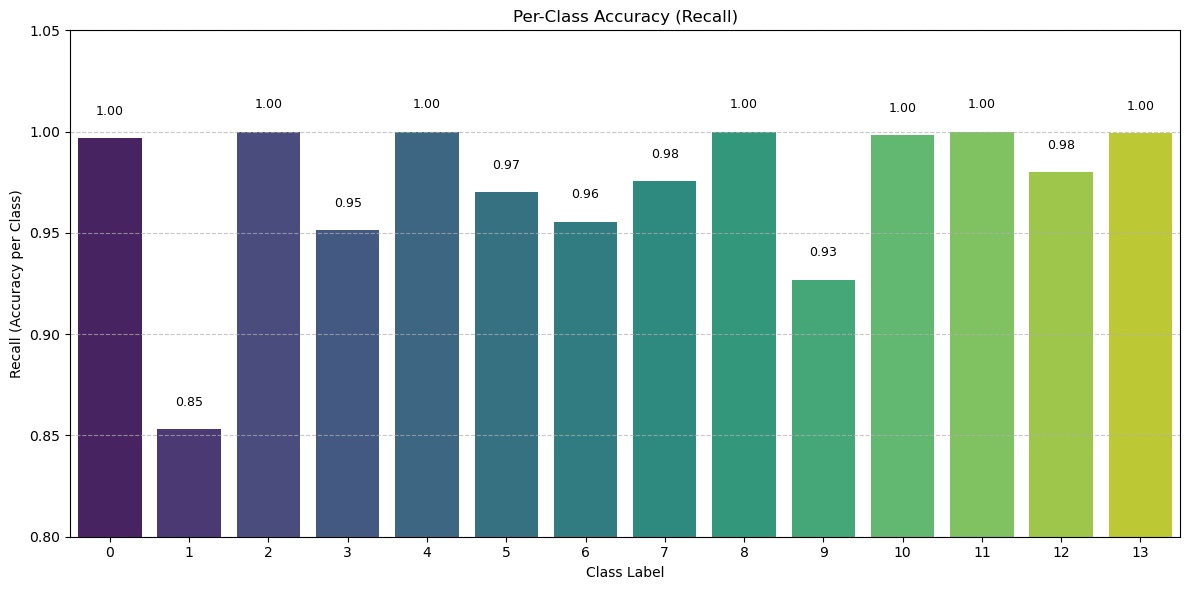

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


# Class labels (you can customize the labels if needed)
class_labels = list(range(14))  # Classes 0 to 13

# Per-class recall (from your classification report)
recall_scores = [
    0.9969,  # class 0
    0.8531,  # class 1
    1.0000,  # class 2
    0.9513,  # class 3
    1.0000,  # class 4
    0.9702,  # class 5
    0.9556,  # class 6
    0.9756,  # class 7
    1.0000,  # class 8
    0.9269,  # class 9
    0.9981,  # class 10
    1.0000,  # class 11
    0.9800,  # class 12
    0.9994   # class 13
]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_scores, palette='viridis')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy per Class)')
plt.title('Per-Class Accuracy (Recall)')
plt.ylim(0.8, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(class_labels)
# Display values on bars
for i, rec in enumerate(recall_scores):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()
